In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

In [3]:
import networkx as nx
from scipy.sparse import csr_array
from graspologic.simulations import rdpg
#from scipy.linalg import irlba
#from scipy.spatial import procrustes
%run GraphEncoder.ipynb
import leidenalg as la
import igraph as ig
import scipy.sparse as sp
import random
import math
import seaborn as sns

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from gae.layers import GraphConvolution
from gae.model import GCNModelVAE
from gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score
from gae.optimizer import loss_function

In [5]:
# Define a function for dot product sampling
def sample_dot_product(lpvs):
        num_nodes = lpvs.shape[1]
        similarity_matrix = np.dot(lpvs.T, lpvs)
        np.fill_diagonal(similarity_matrix, 0)  # Remove self-similarity
        return nx.Graph(similarity_matrix)

def adj_to_edg(A):
    """
      input is the symmetric adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """
    # check the len of the second dimenson of A
    if A.shape[1] <= 3:
      edg = A
    else:
      n = A.shape[0]
      # construct the initial edgg_list matrix with the size of (edg_sum, 3)
      edg_list = []
      for i in range(n):
        for j in range(i, n):
          if A[i,j] > 0:
            row = [i, j, A[i,j]]
            edg_list.append(row)
      edg = np.array(edg_list)
    return edg

def procrustes(X, Y, type="I"):
    if type == "C":
        X = X / np.linalg.norm(X, ord="fro") * np.sqrt(X.shape[0])
        Y = Y / np.linalg.norm(Y, ord="fro") * np.sqrt(Y.shape[0])
    if type == "D":
        tX = np.sum(X ** 2, axis=1)
        tX[tX <= 1e-15] = 1
        tY = np.sum(Y ** 2, axis=1)
        tY[tY <= 1e-15] = 1
        X = X / np.sqrt(tX)#[:, np.newaxis]
        Y = Y / np.sqrt(tY)#[:, np.newaxis]

    tmp = X.T @ Y
    U, s, Vt = np.linalg.svd(tmp,full_matrices=True)
    W = U @ Vt.T
    error = np.linalg.norm(X @ W - Y, ord="fro")
    
    return {"error": error, "W": W}


In [6]:
def GCN_emb(model, features, adj_norm_matrix, adj_label,n, decay,learning_rate, epochs = 200):
    optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=decay) #weight decay is important!

    # get class weight
    pos_weight = ((adj_label.shape[0] * adj_label.shape[0] - adj_label.sum()) / adj_label.sum())
    # get adj norm
    adj_norm = adj_label.shape[0] * adj_label.shape[0] / float((adj_label.shape[0] *adj_label.shape[0] - adj_label.sum()) * 2)

    # Training the VAE   
    while True: #we can try 20 different random weight init runs to get an average 
        # initialize weights randomly => impact on convergence
        model.gc1.reset_parameters()
        model.gc2.reset_parameters()
        model.gc3.reset_parameters()  
        # Training
        for epoch in range(0, epochs + 1):
            model.train()
            optimizer.zero_grad()
            # ===================forward=====================
            adj_hat, mu, logvar = model(features,adj_norm_matrix)        
            loss = loss_function(adj_hat,adj_label,mu,logvar,n,adj_norm,pos_weight) #might reduce the KL term regularization
            # log
            if epoch == 0:
              init_loss = loss.item()
            # if epoch% 50 == 0:
            #   print('loss: ', loss.item())
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # Check convergence
        if (init_loss-loss.item())/loss.item() > 0.05: 
            break
        else:
          print(model)
          print('not converged yet, reset params and rerun')

  # Get GCN embedding
    with torch.no_grad():
      model.eval()
      adj_hat, mu, logvar = model(features, adj_norm_matrix)
      z = model.reparameterize(mu, logvar) 

    return z

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_graph(adj_):
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten()) #D^-0.5
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()  #D^-0.5 A D^-0.5
    return sparse_mx_to_torch_sparse_tensor(adj_normalized), sparse_mx_to_torch_sparse_tensor(adj_)

def adj_in_out(adj):
    row, col = np.where(adj)
    coo = np.rec.fromarrays([row, col, adj[row, col]], names='row col value'.split())
    out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj.shape[0], adj.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
    adj_norm_matrix, adj_matrix = preprocess_graph(out)
    adj_label = torch.FloatTensor(out.toarray())
    return adj_norm_matrix, adj_matrix, adj_label#, out

In [571]:
# CAUTION DO not RUN
import os
os.makedirs('./sim_data', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

In [595]:
# CAUTION 
# w/o normalized
nvs = np.arange(100, 1501, 200)
#latent = 20
sim = 50
random.seed(118)

ASE_dist = []
GEE_dist = []
GAE_dist = []
n_vs = []
#sim_alldata = pd.DataFrame()
sim_alldata = []

for n in nvs:
    for i in range(sim):
        lpvs = np.random.dirichlet((1,1,1),n) ### 
        lpvs = np.delete(lpvs, 2, 1)
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        
        g = rdpg(lpvs)
        g.astype(int)
        # _ = heatmap(g, title='A random RDPG')
        # Convert the NetworkX graph to an adjacency matrix
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)

        # Generate a complete graph for the first log(n[k])^2 vertices
        ########## change clique size
        #!!ratio = 0.2      
        cliquesize = f'log(n)'     #!! f'{ratio}*n'
        clique_size = math.log(n)             #!!ratio*n
        num_vertices = int(clique_size) ########## change clique size
        full_g = nx.complete_graph(num_vertices)

        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(edges).union(set(full_edges))
        # Create a graph from the merged edges
        graph1 = nx.Graph(all_edges)

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = 2
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)

        #%%%%%%%%%% GEE
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = leidenalg.find_partition(i_graph0, leidenalg.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False)

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        n_vs.append(n)
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = latent
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,n_vs))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist','n'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/sim_data_dirichlet"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata.append(sim_data)


#print(sim_alldata)



In [545]:
# CAUTION
# input saved sim data

from numpy import genfromtxt
simdata = genfromtxt('./sim_data/sim_data50_300.01500.csv', delimiter=',')
#simdata = pd.read_csv ('./sim_data/sim_data50_300.01500.csv',sep=',')
simdata.shape

(401, 4)

In [715]:
# CAUTION

simdata = np.reshape(sim_alldata, (sim*len(nvs), 4))
df = pd.DataFrame(simdata)
df.columns =['ASE_dist','GEE_dist','GAE_dist','N']
meltdf = pd.melt(df, id_vars=['N'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['N', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
finaldf.head(10)

,N,variable,value_min,value_mean,value_max,value_std
0,100.0,ASE_dist,5.542749,6.235043,6.781127,0.268932
1,100.0,GAE_dist,1.517395,2.309228,11.990883,1.448205
2,100.0,GEE_dist,1.912281,10.183052,16.909670,4.788813
3,300.0,ASE_dist,9.192185,9.761108,10.410006,0.289626
4,300.0,GAE_dist,1.502337,2.366953,3.290319,0.419461
5,300.0,GEE_dist,2.039059,16.852556,29.376966,9.169592
6,500.0,ASE_dist,11.313696,12.099038,12.794106,0.272541
7,500.0,GAE_dist,1.567490,2.270059,3.455992,0.440632
8,500.0,GEE_dist,6.957189,26.606587,37.072766,9.050603
9,700.0,ASE_dist,13.136042,13.823329,14.637224,0.342055


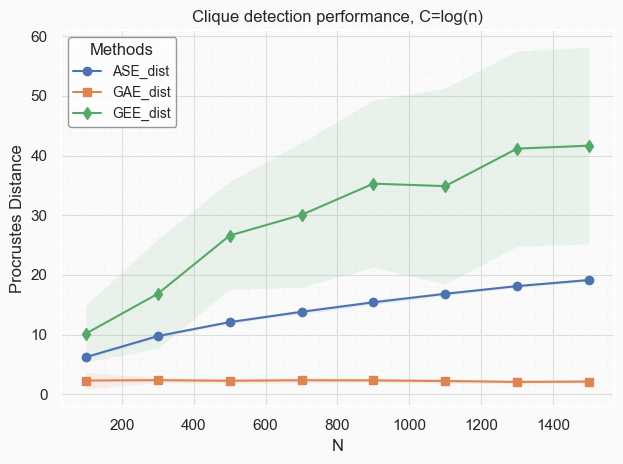

In [599]:
# CAUTION

fig, ax = plt.subplots()
fig.patch.set_facecolor("#fafafa")
ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['N'], group['value_mean'], label=variable)
    ax.fill_between(group['N'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', title='Clique detection performance, C='+cliquesize)
# ax.set_facecolor("white")

# set markers
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
plt.savefig('./plots/C_' + cliquesize + '.png')


In [909]:
# CAUTION
# with normalized

nvs = np.arange(100, 1501, 200)
#latent = 20
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
n_vs = []
#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
        #lpvs = np.random.normal(size=(latent, n))
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        lpvs = np.random.dirichlet((1,1,1),n) ### 
        lpvs = np.delete(lpvs, 2, 1)
        g = rdpg(lpvs,loops=False)
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        # get the norm of adj0
        adj0_norm = sp.linalg.norm(adj0)

        # Generate a complete graph for the first log(n[k])^2 vertices
        ########## change clique size
        #!!ratio = 0.2      
        cliquesize =f'log(n)'      #!!    f'{ratio}*n'
        clique_size = math.log(n)           #   ratio*n 
        num_vertices = int(clique_size) ########## change clique size
        full_g = nx.complete_graph(num_vertices)
        
        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        # Create a graph from the merged edges
        #graph1 = nx.Graph(all_edges)
        graph1 = nx.compose(full_g,graph0)

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = 2
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        #%%%%%%%%%% GEE
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = leidenalg.find_partition(i_graph0, leidenalg.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
        n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False)

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = latent
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        GAE_nml.append(GAE_n)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
                                ASE_nml,GEE_nml,GAE_nml,n_vs))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist',
                                                 'ASE_nml','GEE_nml','GAE_nml','n'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/sim_data_nml_dirichletlogn"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



In [868]:
print(graph0.has_edge(0, 3))
print(graph1.has_edge(0, 3))
graph0.number_of_nodes()

False
True


100

In [881]:
# CAUTION

data = np.reshape(sim_alldata_nml, (sim*len(nvs), 7))
df = pd.DataFrame(data)
df.columns =['ASE_dist','GEE_dist','GAE_dist','ASE_nml','GEE_nml','GAE_nml','N']
meltdf = pd.melt(df, id_vars=['N'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['N', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
finaldf['D_R'] = finaldf['variable'].apply(lambda x: 'Dist' if x in ['GEE_dist', 'ASE_dist', 'GAE_dist'] else 'Normalized')
finaldf.tail(3)


,N,variable,value_min,value_mean,value_max,value_std,D_R
45,1500.0,GAE_nml,0.020013,0.031836,0.057446,0.006379,Normalized
46,1500.0,GEE_dist,15.317462,47.424446,64.261706,11.941223,Dist
47,1500.0,GEE_nml,0.021624,0.067171,0.090949,0.016968,Normalized


In [882]:
finaldf2 = finaldf
finaldf2['upper']=finaldf2['value_mean']+finaldf2['value_std']
finaldf2['lower']=finaldf2['value_mean']-finaldf2['value_std']
finaldf2.head(3)

,N,variable,value_min,value_mean,value_max,value_std,D_R,upper,lower
0,100.0,ASE_dist,1.483683,4.022353,4.973021,0.744349,Dist,4.766702,3.278004
1,100.0,ASE_nml,0.029853,0.085966,0.106200,0.016285,Normalized,0.102251,0.069681
2,100.0,GAE_dist,3.811473,6.053044,10.536645,1.703383,Dist,7.756426,4.349661


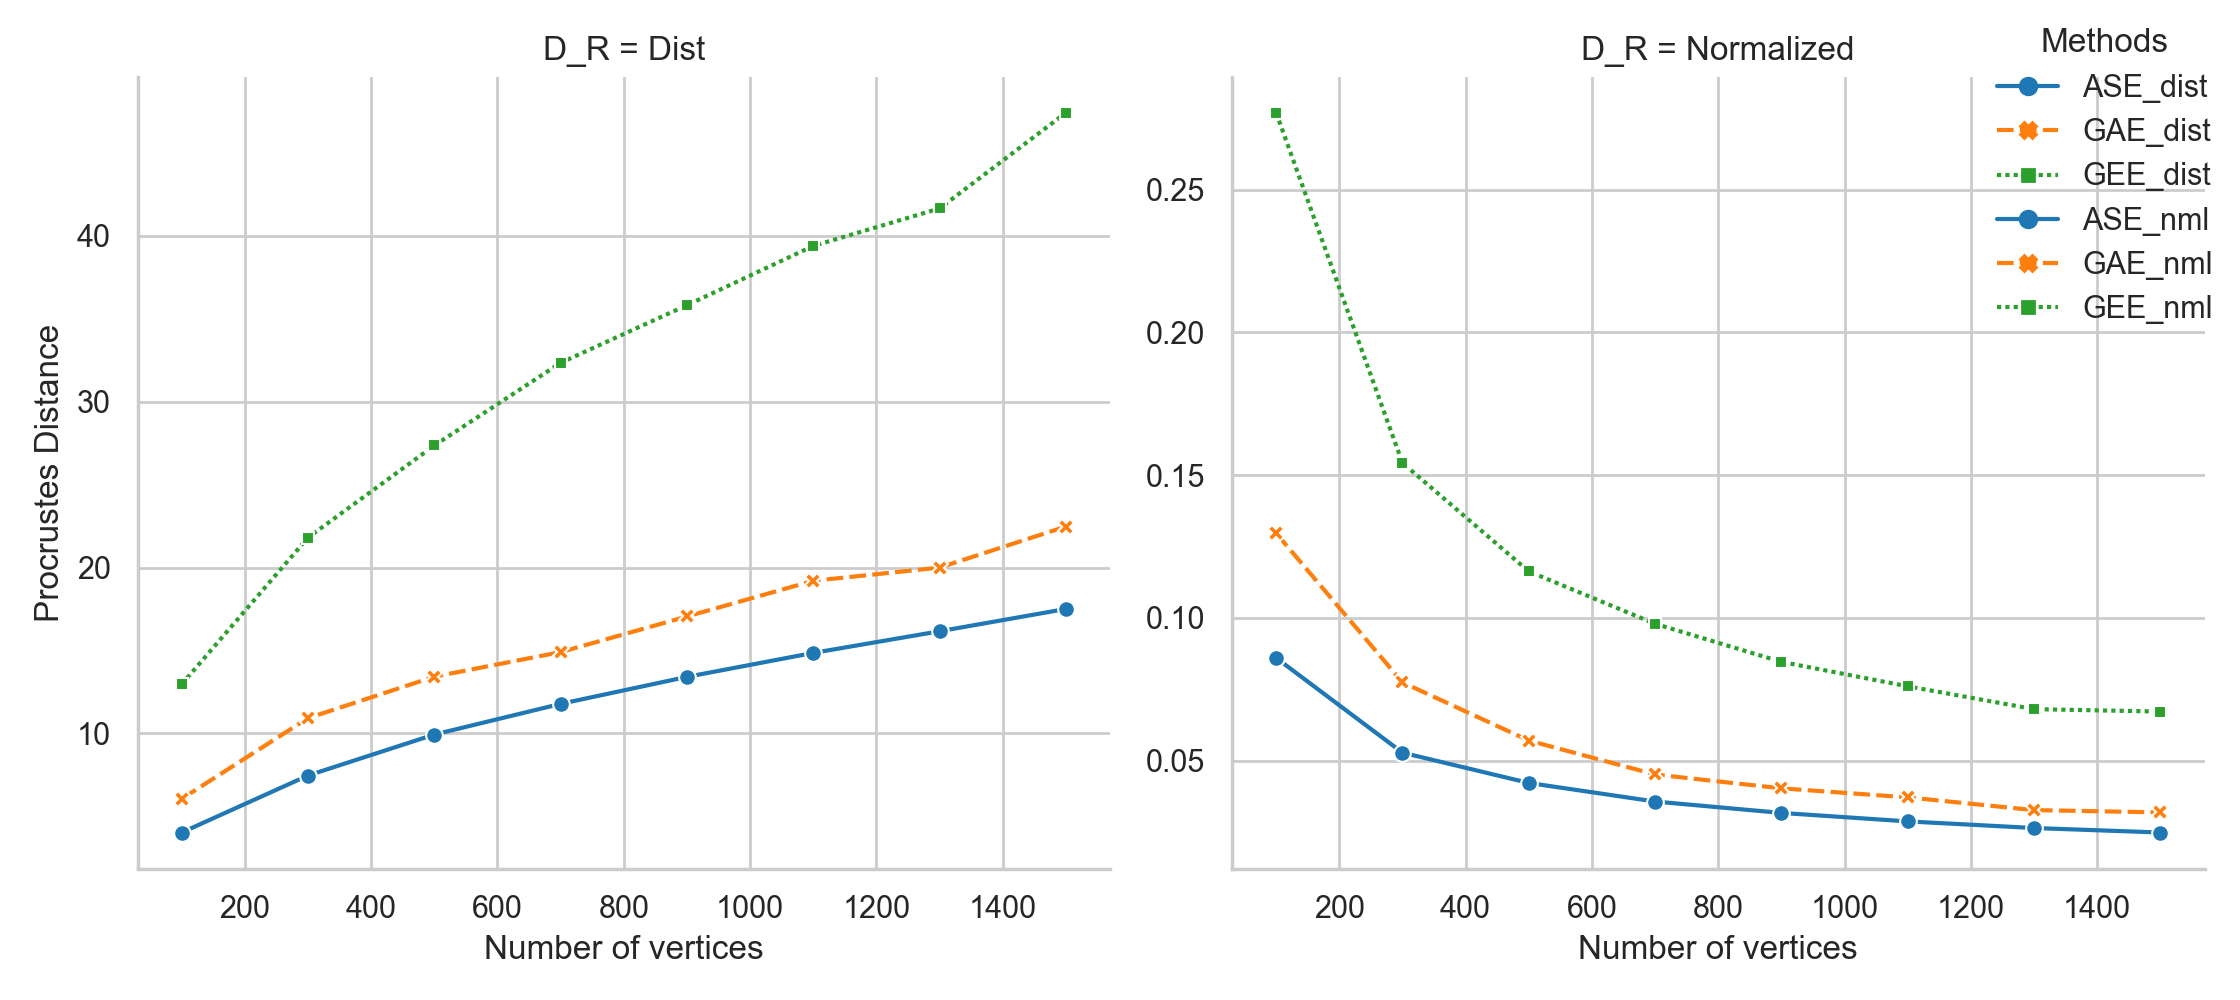

In [883]:
# Set the style for the plot
sns.set(style="whitegrid")

def draw_subplot(data, color):
    sns.lineplot(data=data, x="N", y="value_mean", color='black')
    sns.lineplot(data=data, x="N", y="upper", color='grey')
    sns.lineplot(data=data, x="N", y="lower", color='grey')
    line = plt.gca().lines
    plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='grey', alpha=.5)
#     plt.axhline(y=0, ls='--', c='red')
#     plt.margins(x=0)
    
    
# Facet wrap
g = sns.FacetGrid(finaldf2, col='D_R', col_wrap=2, height=5,sharey=False)
g.map_dataframe(sns.lineplot, x='N', y='value_mean', hue='variable', palette='tab10',
                style = 'variable', markers=True)
#g.map_dataframe(draw_subplot)
g.set_axis_labels("Number of vertices", "Procrustes Distance")
g.set_titles("D_R = {col_name}")
g.add_legend(title="Methods",loc = 1)

ax1, ax2 = g.axes


plt.tight_layout()
plt.show()

In [657]:
from plotnine import *

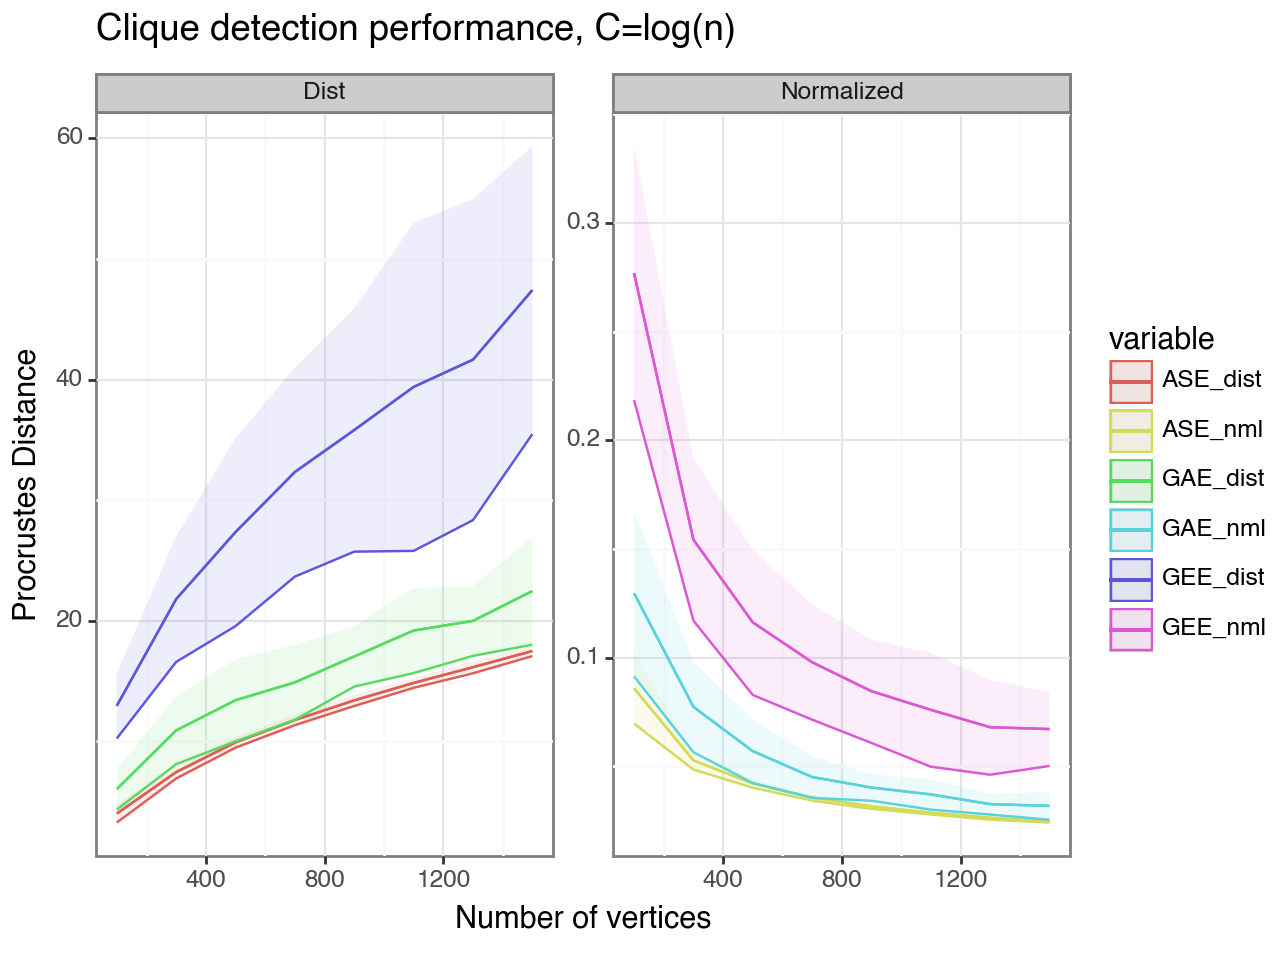

<Figure Size: (640 x 480)>

In [884]:
 (
  ggplot(finaldf,aes(x = 'N', y = 'value_mean',color = 'variable')) 
  #+aes(x = 'N', y = 'value_mean',fill = 'variable')
  +geom_line() +
  #geom_errorbar(aes(x = N, y = Mean, ymin = Mean-Sd,
  #                    ymax = Mean+Sd,color=variable),width=0.005)+
  geom_ribbon(data = finaldf, 
              mapping= aes(ymax='upper',ymin='lower',fill = 'variable'),
              alpha=0.1) +
  theme_bw() +
  #scale_x_continuous(name = "N", breaks = N) +
  ylab( "Procrustes Distance") +
  xlab("Number of vertices") +
  ggtitle("Clique detection performance, C=log(n)") + #sqrt(log(n[k])^4) log(n[k])
  #scale_color_discrete(name = "Variable") +
  #scale_fill_discrete(name = "Variable") +
  # scale_linetype_discrete(name = "Variable")
  facet_wrap(['D_R'],scales = 'free')
 )


,ASE_dist,GEE_dist,GAE_dist,ASE_nml,GEE_nml,GAE_nml,N
0,4.657939,12.583588,9.280357,0.105051,0.283800,0.209302,100.0
1,4.406886,12.080250,7.456867,0.096396,0.264243,0.163111,100.0
2,4.211028,15.346216,3.751930,0.086463,0.315097,0.077037,100.0
3,4.698558,15.388493,9.934488,0.104438,0.342051,0.220821,100.0
4,4.438631,12.251252,8.719919,0.096813,0.267217,0.190194,100.0
...,...,...,...,...,...,...,...
395,0.463564,36.692592,19.638706,0.000650,0.051476,0.027551,1500.0
396,0.398289,47.784041,22.134495,0.000562,0.067388,0.031215,1500.0
397,0.427682,38.656682,22.009073,0.000609,0.055088,0.031364,1500.0
398,0.418996,32.653728,23.778862,0.000592,0.046116,0.033582,1500.0


In [88]:
# CAUTION 
# read dataset
#readdata = genfromtxt('./sim_data/sim_data_nml_dirichletlog(n)^21500.csv', delimiter=',')
readdata = pd.read_csv ('./sim_data/sim_data_nml_dirichlet0.20.2*n1500.csv',sep=',')
#data = np.reshape(readdata, (sim*len(nvs), 7))
#df = pd.DataFrame(data)
readdata.columns =['ASE_dist','GEE_dist','GAE_dist','ASE_nml','GEE_nml','GAE_nml','N']
distdf = readdata[['ASE_dist','GEE_dist','GAE_dist','N']]
meltdf = pd.melt(distdf, id_vars=['N'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['N', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
#finaldf['D_R'] = finaldf['variable'].apply(lambda x: 'Dist' if x in ['GEE_dist', 'ASE_dist', 'GAE_dist'] else 'Normalized')

# get sub-dataframe for the distance plot
distdf = readdata[['ASE_dist','GEE_dist','GAE_dist']]
distdf.head(3)


,ASE_dist,GEE_dist,GAE_dist
0,4.446945,12.336628,7.972620
1,4.270976,12.937741,9.410459
2,2.890573,16.275986,8.156236


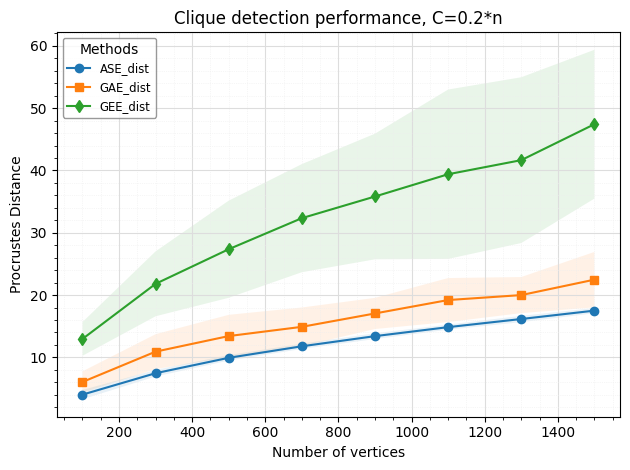

In [91]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['N'], group['value_mean'], label=variable)
    ax.fill_between(group['N'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, C=0.2*n')#+cliquesize)
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
plt.savefig('./plots/C_diri0.2n.png') #+ cliquesize + '.png')


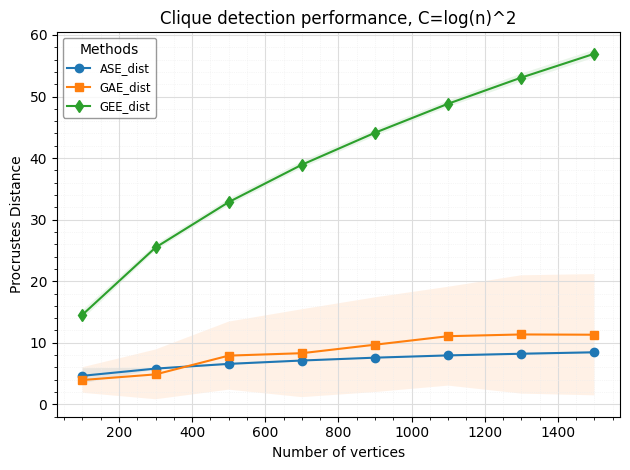

In [83]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['N'], group['value_mean'], label=variable)
    ax.fill_between(group['N'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', title='Clique detection performance, C='+cliquesize)
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
plt.savefig('./plots/C_diri_3rdpglogn2' + cliquesize + '.png')


## Try the 3 cluster RDPG

In [55]:
def ARDPG(n,k):
    A = np.zeros((n,n))
    X = np.random.uniform(0.0, 1.0, (n,1))
    for i in range(0,n):
        if y[i] == 1:
            X[i,:] = np.random.beta(1,3)
        elif y[i] == 2:
            X[i,:] = np.random.beta(3,3)
        else:
            X[i,:] = np.random.beta(3,1)
    P=np.matmul(X,X.transpose())
    for i in range(0,n):
        for j in range(1,n):
            A[i,j]=np.random.binomial(1,P[i,j])
    for i in range(0,n):
        for j in range(0,i):
            A[i,j] = A[j,i]
            A[i,i]=0
    return A

def gety(n):
    y = np.zeros((n,1))
    #np.random.seed(2)
    for i in range(0,n):
        y[i,0] = np.random.choice(np.arange(1, 4), p=[0.2, 0.3,0.5])
    return(y)

def latent3y(n):
    X1 = np.random.dirichlet((2,1,1),int(n/3))
    X2 = np.random.dirichlet((1,1,2),int(n/3))
    X3 = np.random.dirichlet((1,2,1),(n-int(n/3)*2))
    together = np.concatenate((X1, X2,X3))
    latent = np.delete(together, 2, 1)
    ty = [1,2,3]
    y = np.repeat(ty, n/3)
    return(latent,y)
  

(600,)

In [74]:
# CAUTION
# with normalized
# 3 cluaster RDPG

nvs = np.arange(100, 1501, 200)
d = 3
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
GAE_dist = []
GAE_nml = []
n_vs = []
#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
        #lpvs = np.random.normal(size=(latent, n))
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        #lpvs = np.random.dirichlet((1,1,1),n) ### 
        #lpvs = np.delete(lpvs, 2, 1)
        latent, ys = latent3y(n)
        g = rdpg(latent,loops=False)
        # _ = heatmap(g, title='A random RDPG')
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        # get the norm of adj0
        adj0_norm = sp.linalg.norm(adj0)

        # Generate a complete graph for the first log(n[k])^2 vertices
        ########## change clique size
        ratio = 0.2      
        cliquesize = f'log(n)^2'    #!!       f'{ratio}*n'
        clique_size = math.log(n)**2        ###     ratio*n   
        num_vertices = int(clique_size) ########## change clique size
        full_g = nx.complete_graph(num_vertices)
        
        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        # Create a graph from the merged edges
        #graph1 = nx.Graph(all_edges)
        graph1 = nx.compose(full_g,graph0)

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = 3
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        #%%%%%%%%%% GEE
        n_comms = 3
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.CPMVertexPartition(i_graph0,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
#         y0 = leidenalg.find_partition(i_graph0, leidenalg.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
#         n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False)

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        GAE_nml.append(GAE_n)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,
                                ASE_nml,GEE_nml,GAE_nml,n_vs))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','GAE_dist',
                                                 'ASE_nml','GEE_nml','GAE_nml','n'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/sim_data_nml_dirichlet3rdpglog2"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (900 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (900 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (900 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphCon

In [61]:
print(sim_alldata_nml)

[     ASE_dist   GEE_dist   GAE_dist   ASE_nml   GEE_nml   GAE_nml       n
0    0.249236  13.973512   0.523956  0.005323  0.298459  0.011191   100.0
1    0.447170  15.440426   2.693231  0.009419  0.325224  0.056728   100.0
2    0.169667  14.848233   1.269111  0.003526  0.308536  0.026371   100.0
3    0.345812  15.131404   1.904388  0.007664  0.335344  0.042205   100.0
4    0.355205  15.152770   0.860214  0.007150  0.305014  0.017315   100.0
..        ...        ...        ...       ...       ...       ...     ...
395  0.079362  55.893732  24.913204  0.000113  0.079370  0.035377  1500.0
396  0.045187  57.625359  26.421291  0.000064  0.081633  0.037429  1500.0
397  0.047219  57.501985  29.350922  0.000067  0.081276  0.041486  1500.0
398  0.096564  57.060841  29.001255  0.000138  0.081327  0.041335  1500.0
399  0.030423  57.196578  14.674850  0.000043  0.081364  0.020876  1500.0

[400 rows x 7 columns]]


In [ ]:
# CAUTION
# with normalized
# 3 cluaster RDPG
##### with randomly select vertices 

nvs = np.arange(100, 1501, 200)
d = 3
sim = 50
random.seed(118)

ASE_dist = []
ASE_nml = []
GEE_dist = []
GEE_nml = []
VGAE_dist = []
VGAE_nml = []
n_vs = []
#sim_alldata = pd.DataFrame()
sim_alldata_nml = []

for n in nvs:
    for i in range(sim):
        #lpvs = np.random.normal(size=(latent, n))
        #lpvs_normalized = np.apply_along_axis(lambda x: np.abs(x) / np.sqrt(np.sum(x**2)), axis=0, arr=lpvs)
        #lpvs = np.random.dirichlet((1,1,1),n) ### 
        #lpvs = np.delete(lpvs, 2, 1)
        latent, ys = latent3y(n)
        g = rdpg(latent,loops=False)
        # _ = heatmap(g, title='A random RDPG')
        g.astype(int)
        adj0 = csr_array(g)
        graph0 = nx.from_numpy_matrix(g,parallel_edges=False, create_using=None)
        
        # get the norm of adj0
        adj0_norm = sp.linalg.norm(adj0)

        # Generate a complete graph for the first log(n[k])^2 vertices
        ########## change clique size
        ratio = 0.2      
        cliquesize = f'log(n)^2'    #!!       f'{ratio}*n'
        clique_size = math.log(n)**2        ###     ratio*n   
        num_vertices = int(clique_size) ########## change clique size
        c_vertices = random.sample(range(0,n),num_vertices) # randomly select vertices to form clique
        
        full_g = nx.complete_graph(c_vertices)
        
        # Get the edges of the complete graph
        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(full_edges).union(set(edges))
        # Create a graph from the merged edges
        #graph1 = nx.Graph(all_edges)
        graph1 = nx.compose(full_g,graph0)

        # Convert the graph to an adjacency matrix
        adj1 = nx.to_numpy_array(graph1, dtype=int)

        #%%%%%%%%%%%% ASE
        d = 3
        ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
        ASE_Xhat0 = ase.fit_transform(adj0)
        #ASE_Xhat0
        ASE_Xhat1 = ase.fit_transform(adj1)
        #ASE_Xhat1
        #pairplot(Xhat0, title='2-component embedding', height=2)
        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)
        ASE_d = ASE_d['error']
        ASE_dist.append(ASE_d)
        
        ASE_n = ASE_d/adj0_norm
        ASE_nml.append(ASE_n)

        #%%%%%%%%%% GEE
        n_comms = 3
        edgelist0 = adj_to_edg(adj0)
        i_graph0 = ig.Graph.from_networkx(graph0)
        y0 = la.CPMVertexPartition(i_graph0,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
#         y0 = leidenalg.find_partition(i_graph0, leidenalg.ModularityVertexPartition)
        label_num = []
        for k in range(len(y0)):
            y = len(y0[k])
            label_num.append(y)
        values = np.arange(len(label_num))
        label0 = np.repeat(values, label_num) 
        label0= label0.reshape((n,1))
        Z0,W0 = graph_encoder_embed(edgelist0,label0,n,correlation=False)

        edgelist1 = adj_to_edg(adj1)
        i_graph1 = ig.Graph.from_networkx(graph1)
#         n_comms = len(label_num)
        y1 = la.CPMVertexPartition(i_graph1,initial_membership=np.random.choice(n_comms, n),
                           resolution_parameter=0.5)
        #y1 = leidenalg.find_partition(i_graph1, leidenalg.ModularityVertexPartition)
        label_num1 = []
        for j in range(len(y1)):
            y = len(y1[j])
            label_num1.append(y)
        values1 = np.arange(len(label_num1))
        label1 = np.repeat(values1, label_num1) 
        label1= label1.reshape((n,1))
        Z1,W1 = graph_encoder_embed(edgelist1,label1,n,correlation=False)

        GEE_d = procrustes(Z1,Z0)
        GEE_d = GEE_d['error']
        GEE_dist.append(GEE_d)
        
        GEE_n = GEE_d/adj0_norm
        GEE_nml.append(GEE_n)
        
        
        #%%%%%%%%%%%%%%%%% GAE
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates
        
        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        VGAE_dist.append(GAE_d)
        
        GAE_n = GAE_d/adj0_norm
        VGAE_nml.append(GAE_n)
        
        n_vs.append(n)
        
           
    sim_data = np.column_stack((ASE_dist, GEE_dist,VGAE_dist,
                                ASE_nml,GEE_nml,VGAE_nml,n_vs))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','VGAE_dist',
                                                 'ASE_nml','GEE_nml','VGAE_nml','n'])
    
    df_id = n.astype(str)
    sim_data.to_csv("./sim_data/rdm_nml_dirichlet3rdpglog2"+cliquesize+df_id+".csv", sep=',', index=False)
    
sim_alldata_nml.append(sim_data)


#print(sim_alldata_nml)



GCNModelVAE(
  (gc1): GraphConvolution (500 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (700 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1100 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun
GCNModelVAE(
  (gc1): GraphConvolution (1100 -> 6)
  (gc2): GraphConvolution (6 -> 3)
  (gc3): GraphConvolution (6 -> 3)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


In [133]:
# CAUTION 
# read dataset
#readdata = genfromtxt('./sim_data/sim_data_nml_dirichletlog(n)^21500.csv', delimiter=',')
readdata = pd.read_csv ('./sim_data/rdm_nml_dirichlet3rdpgloglog(n)1500.csv',sep=',')
#data = np.reshape(readdata, (sim*len(nvs), 7))
#df = pd.DataFrame(data)
readdata.columns =['ASE_dist','GEE_dist','VGAE_dist','ASE_nml','GEE_nml','VGAE_nml','N']
distdf = readdata[['ASE_dist','GEE_dist','GAE_dist','N']]
meltdf = pd.melt(distdf, id_vars=['N'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['N', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
#finaldf['D_R'] = finaldf['variable'].apply(lambda x: 'Dist' if x in ['GEE_dist', 'ASE_dist', 'GAE_dist'] else 'Normalized')

# get sub-dataframe for the distance plot
distdf = readdata[['ASE_dist','GEE_dist','GAE_dist']]
distdf.head(3)


,ASE_dist,GEE_dist,GAE_dist
0,5.737371,13.746422,2.855253
1,5.616657,14.580853,1.982115
2,5.900803,7.952683,1.284643


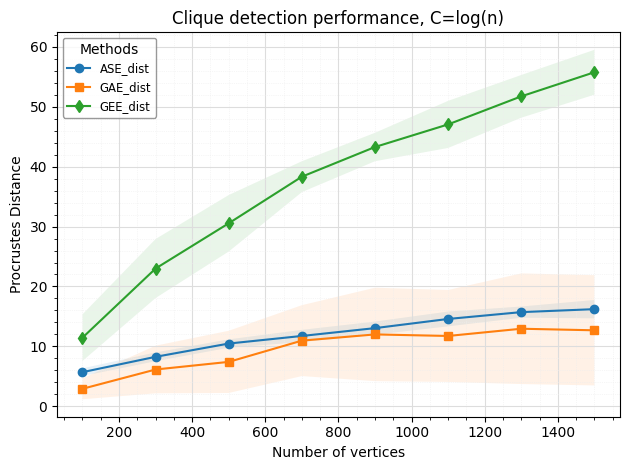

In [135]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['N'], group['value_mean'], label=variable)
    ax.fill_between(group['N'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, C='+cliquesize)
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/rdm_diri_3rdpglogn' + cliquesize + '.png')
